In [1]:
from fiotools import ClatGrid
from pathlib2 import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def clatgrid_helper(scenario, rw_modes = ['read', 'randread', 'write', 'randwrite'],
                    n_clients = [1, 64], skip_bs=[2**7, 2**8, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13],
                    logscale=True, ylim_bw=[0, 7000], ylim_cl=[1, 10**6], verbose=False):
    l_clients = len(n_clients)
    l_rw_modes = len(rw_modes)
    fig_bw, axes_bw = plt.subplots(l_clients, l_rw_modes, figsize=(30, l_clients*8))
    fig_cf, axes_cf = plt.subplots(l_clients, l_rw_modes, figsize=(30, l_clients*8))
    fig_cl, axes_cl = plt.subplots(l_clients, l_rw_modes, figsize=(30, l_clients*8))
    return_this = {}
    for i, clients in enumerate(n_clients):
        return_this[clients] = {}
        for j, rw in enumerate(rw_modes):
            input_dirs = list(Path('/opt/bharat/stackhpc-io-tools/kata-vs-crio/results/%s/beegfs-%s/%s' % (scenario, rw, clients)).iterdir())
            output_dir = Path('/opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/%s/beegfs-%s/%s' % (scenario, rw, clients))
            this = return_this[clients][rw] = ClatGrid(input_dirs, output_dir, granularity=200 if logscale else 2000, scenario=scenario, mode=rw, force=True, logscale=logscale, skip_bs=skip_bs, plot=False, verbose=verbose)
            this.plot_bw(fig=fig_bw, ax=axes_bw[i][j], ylim=ylim_bw)
            this.plot_cf(fig=fig_cf, ax=axes_cf[i][j], ylim=ylim_cl)
            this.plot_cl(fig=fig_cl, ax=axes_cl[i][j], ylim=ylim_cl)
            fig_bw.savefig('aggregate-bw-%s.png' % scenario)
            fig_cf.savefig('aggregate-cf-%s.png' % scenario)
            fig_cl.savefig('aggregate-cl-%s.png' % scenario)            
    return return_this

Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/read-commit-latency.csv in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/read-bandwidth.csv in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/blocksize-vs-commit-latency.png in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/stacked-blocksize-vs-bandwidth.png in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/commit-latency-freq-dist.png in output directory
Deleting existing output data /opt/bharat/stackhpc-io-tools/kata-vs-crio/output-16k-65k/bare/beegfs-read/1/read-commit-latency-freq-dist.csv in output directory
Scanning for fio data in /opt/bharat/stackhpc-io-tools/kata-vs-cr

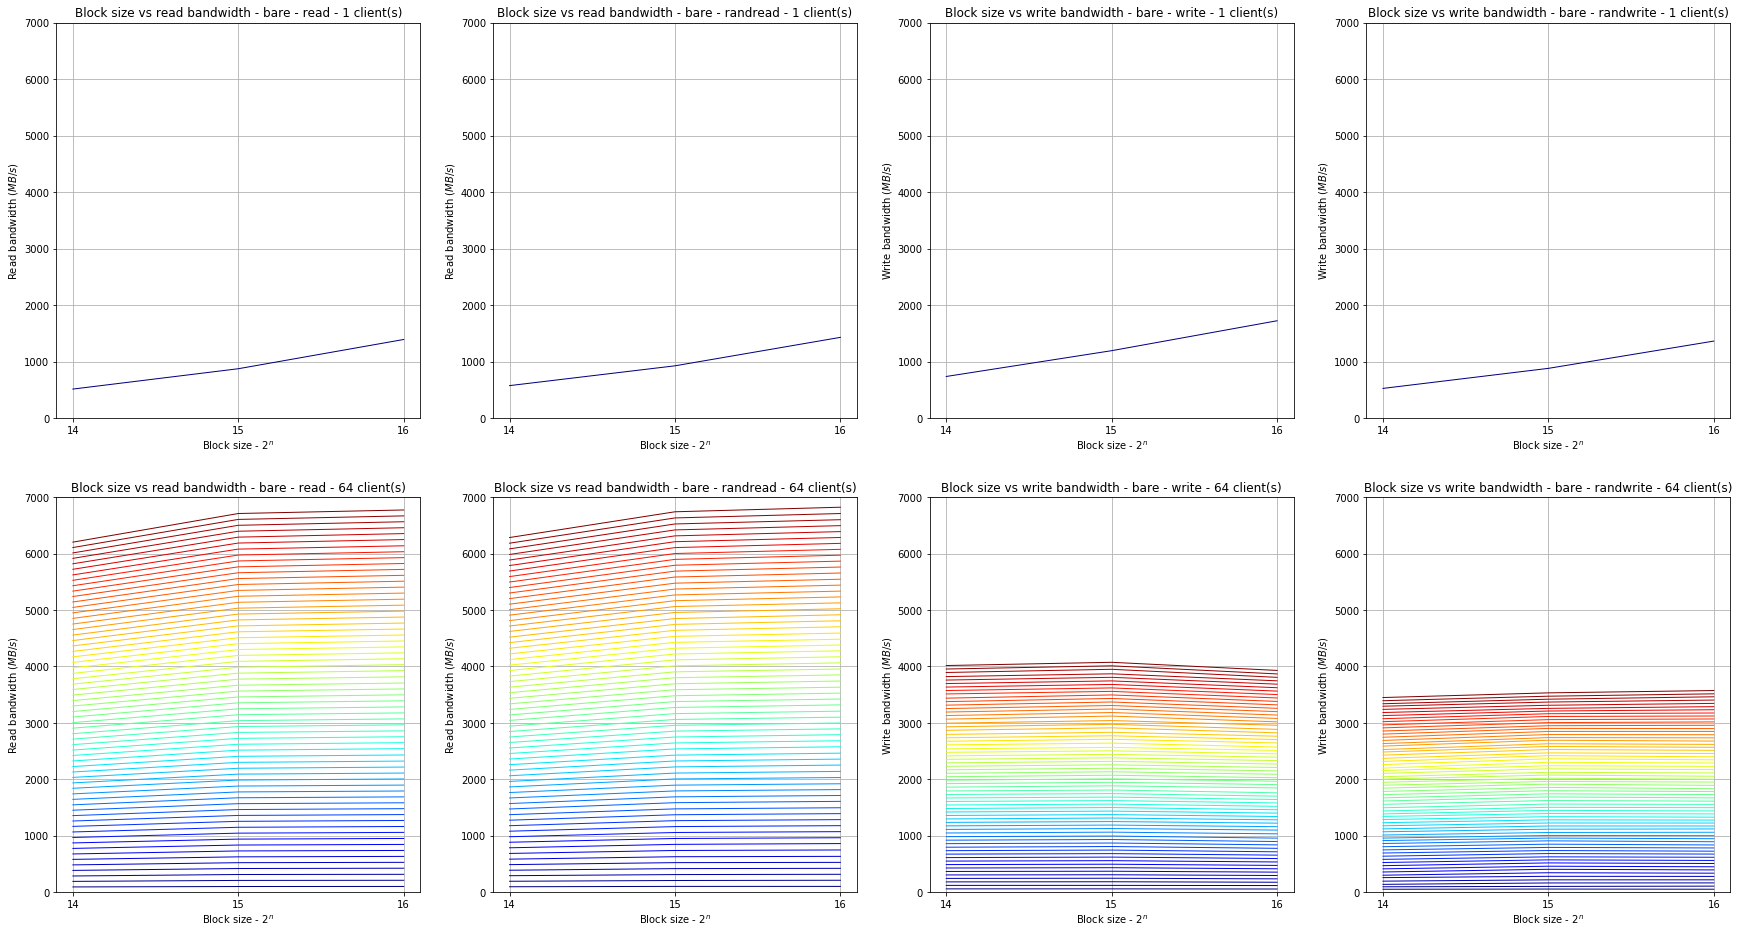

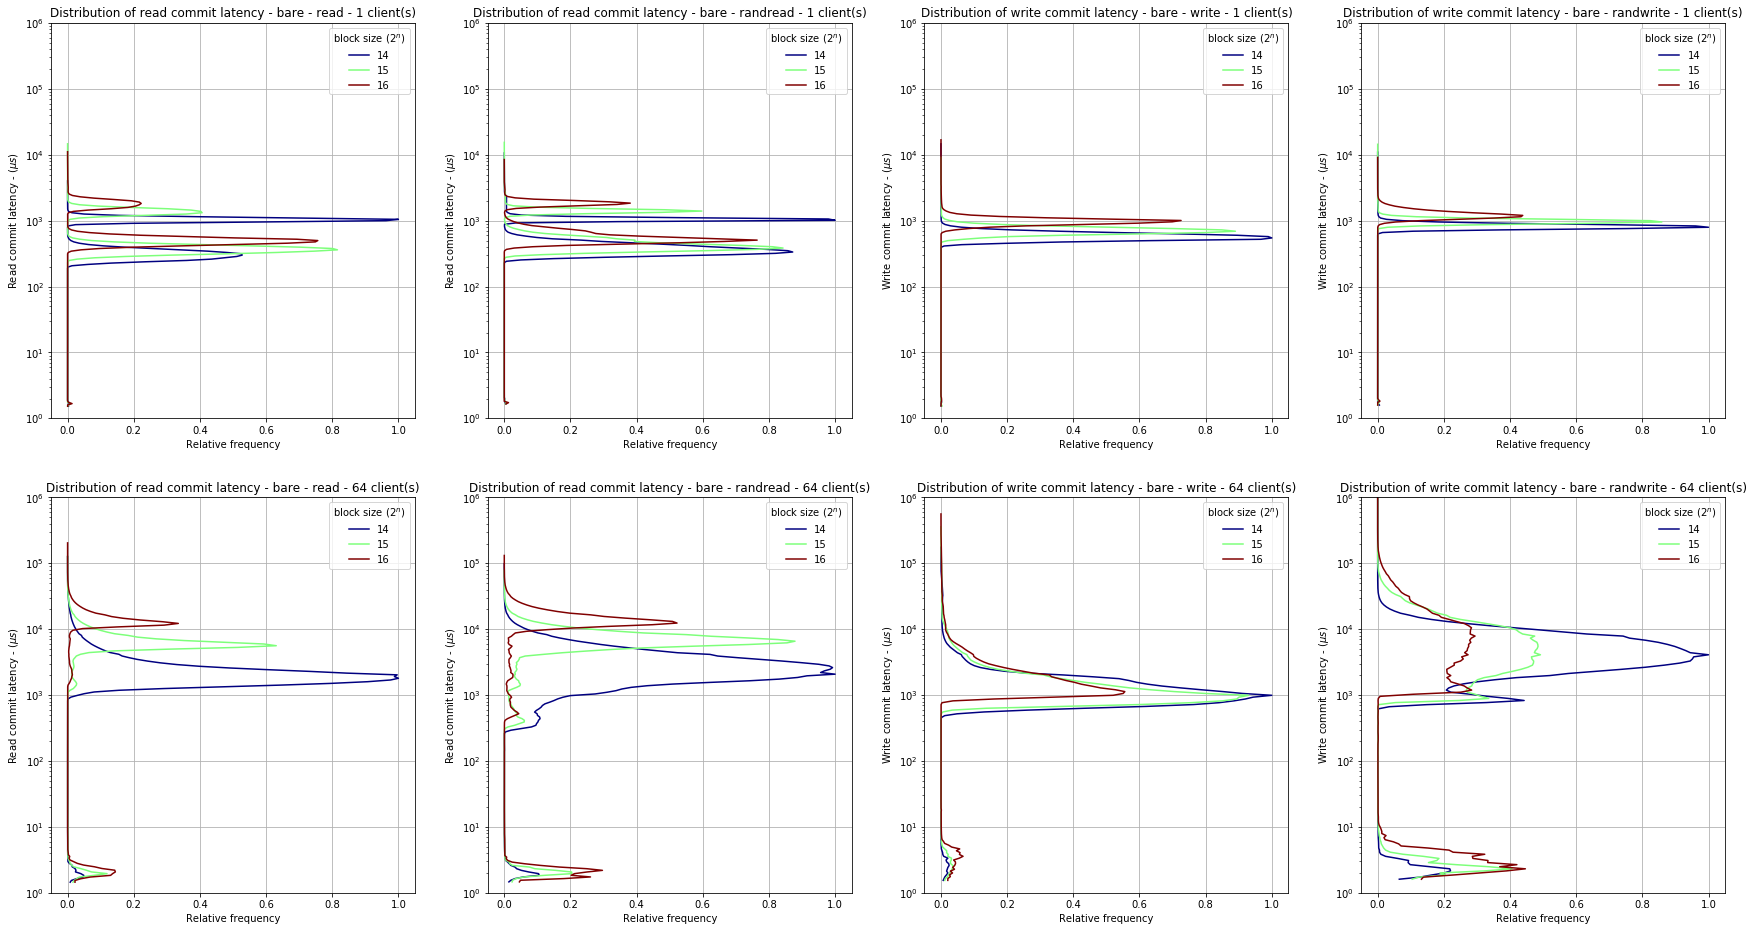

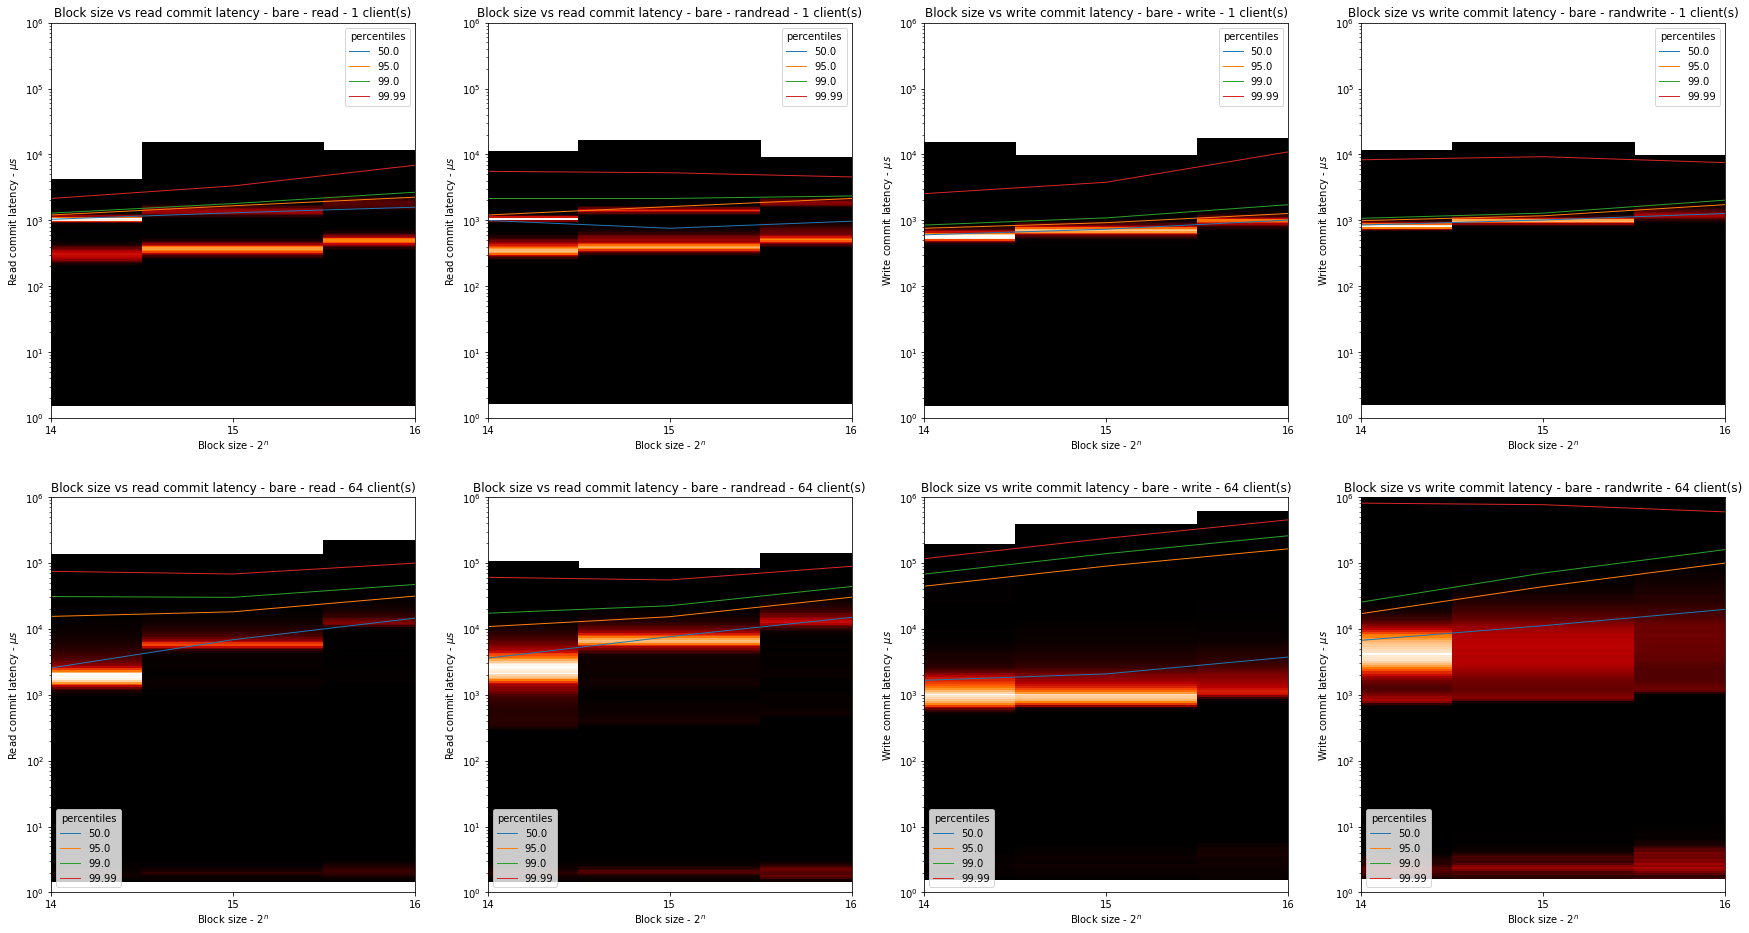

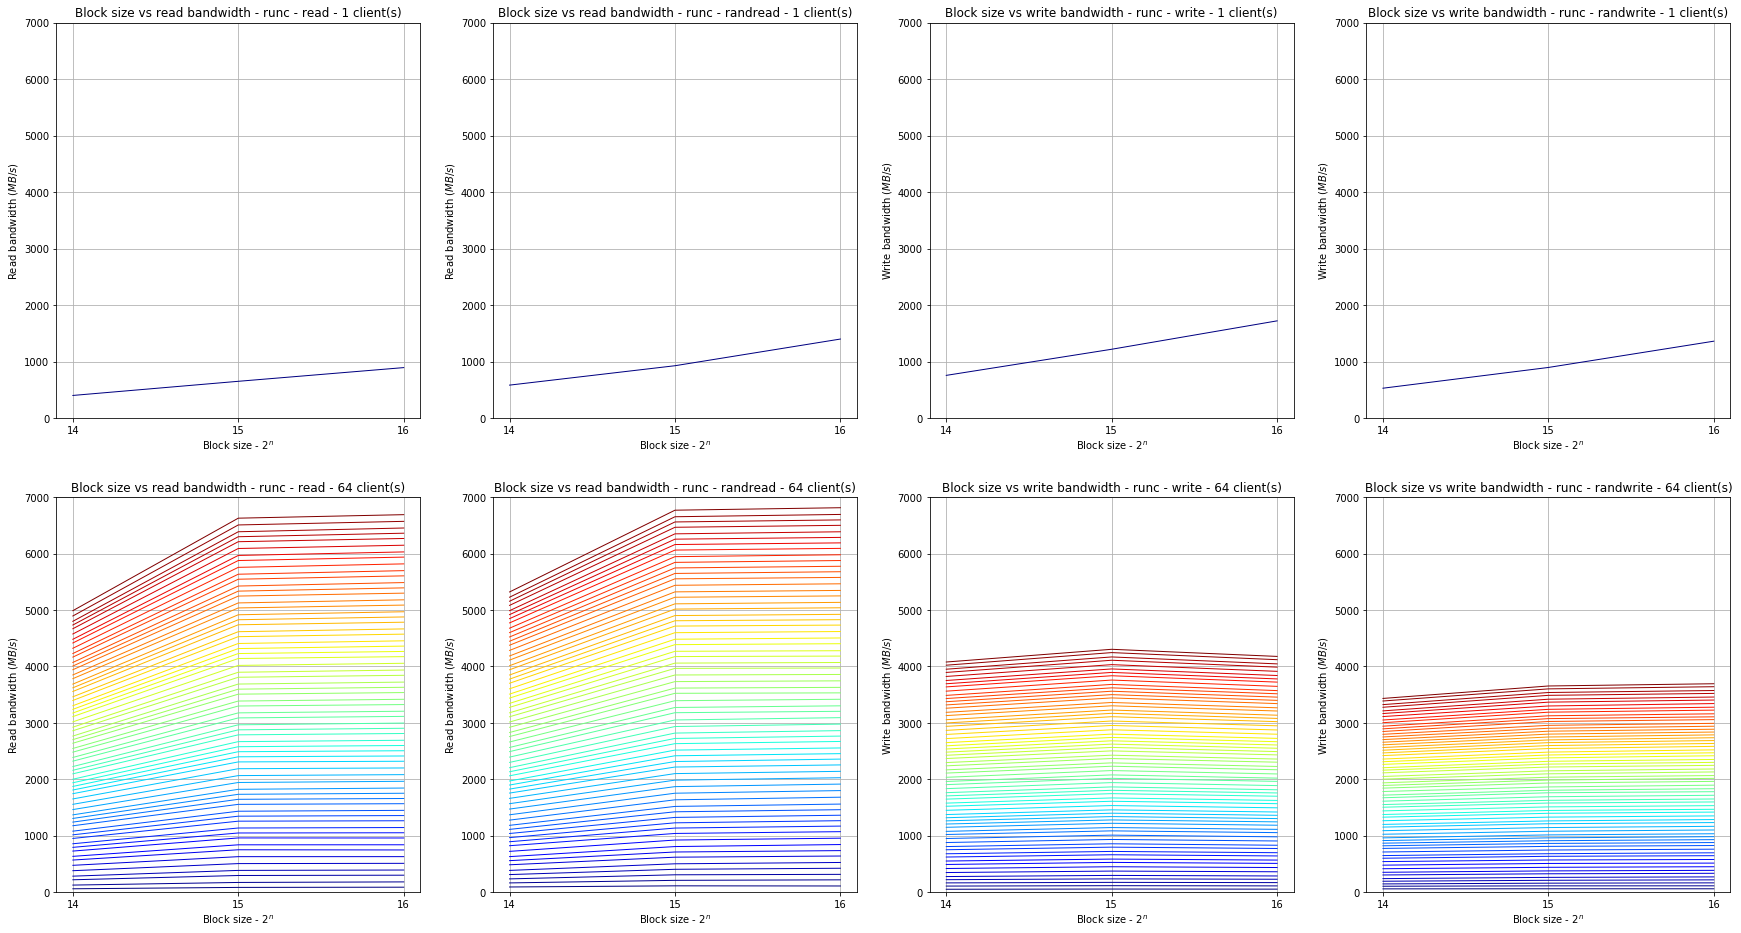

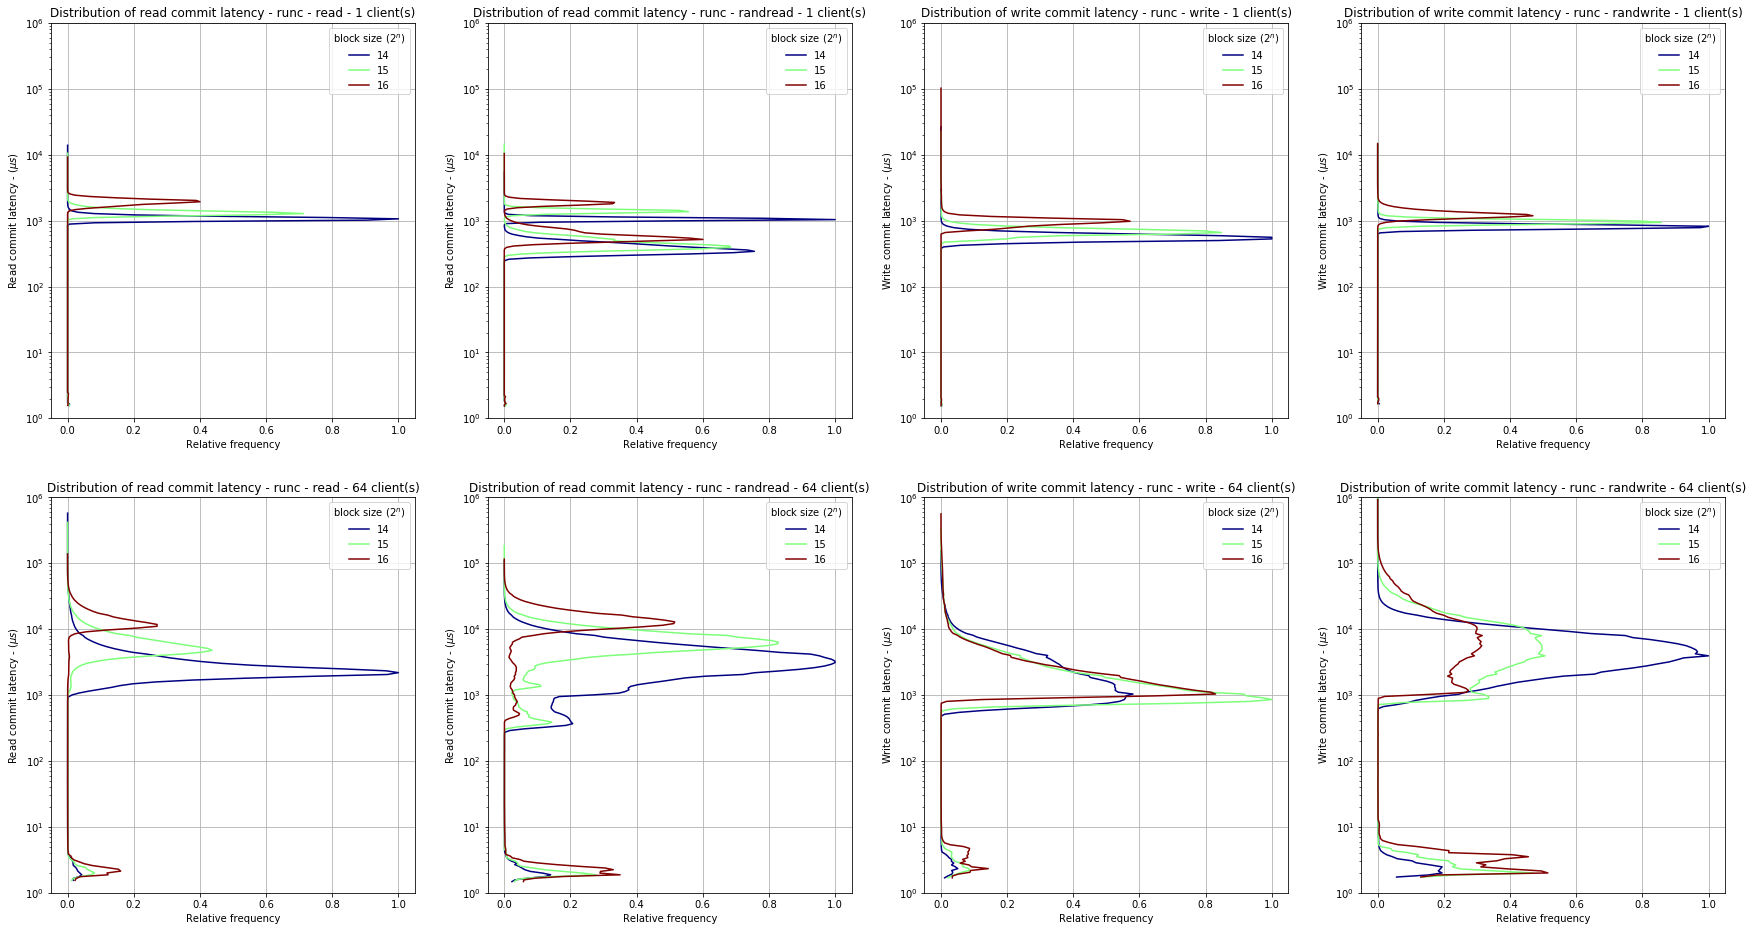

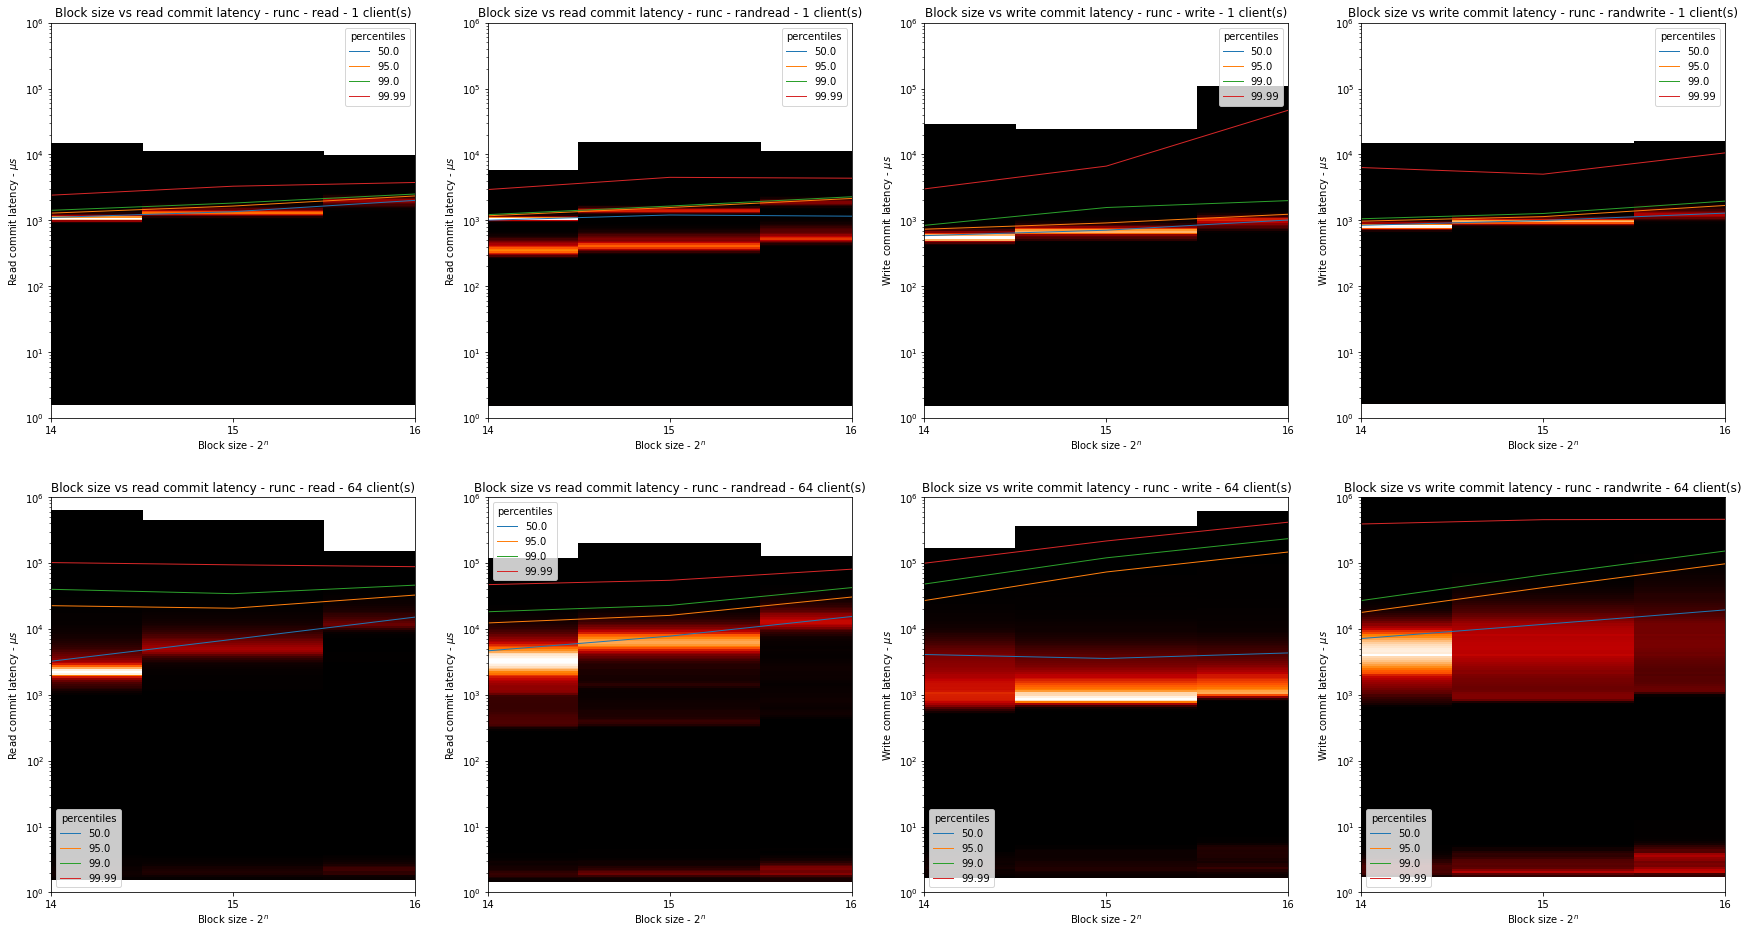

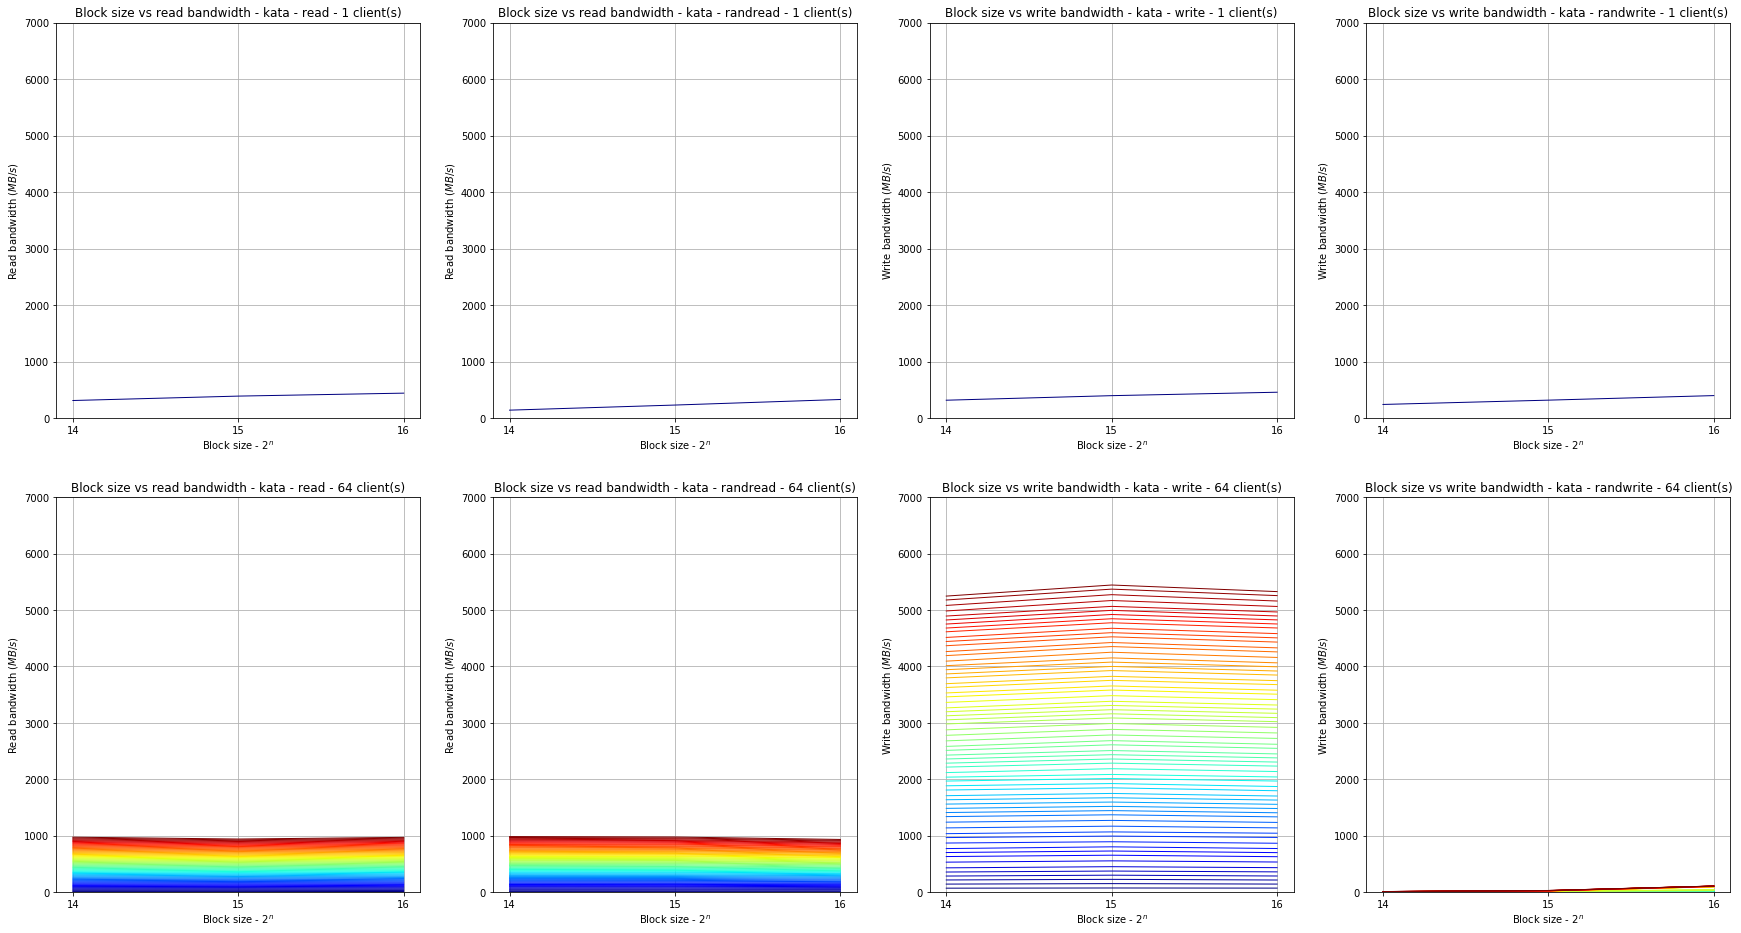

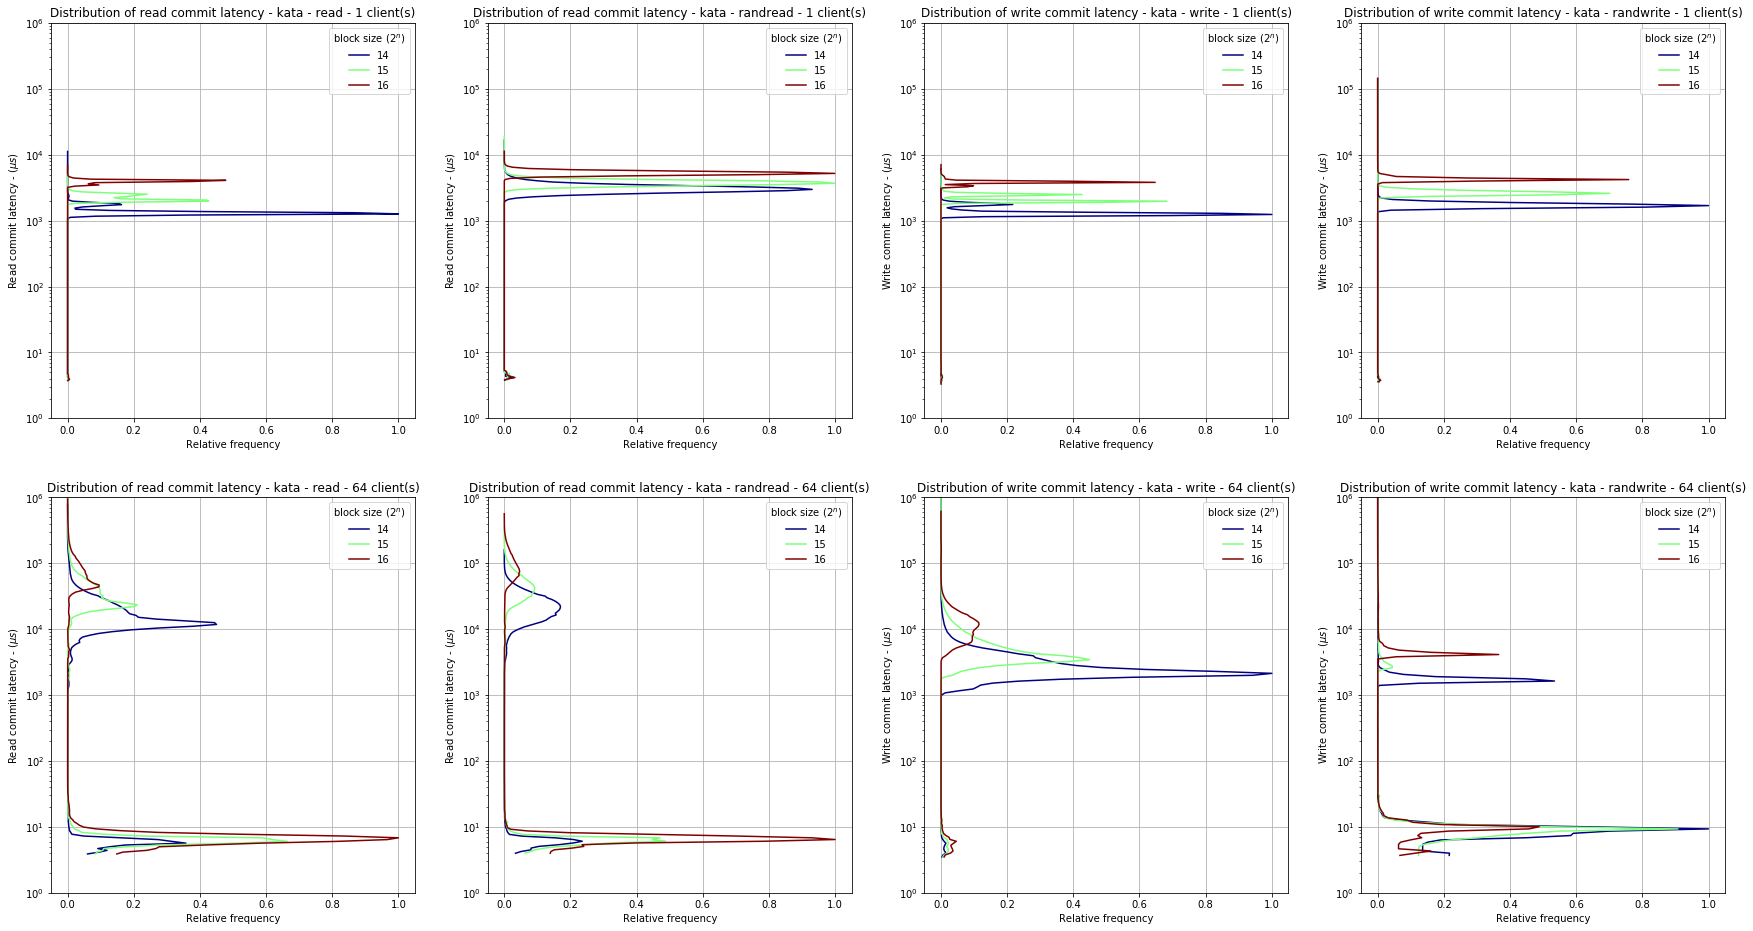

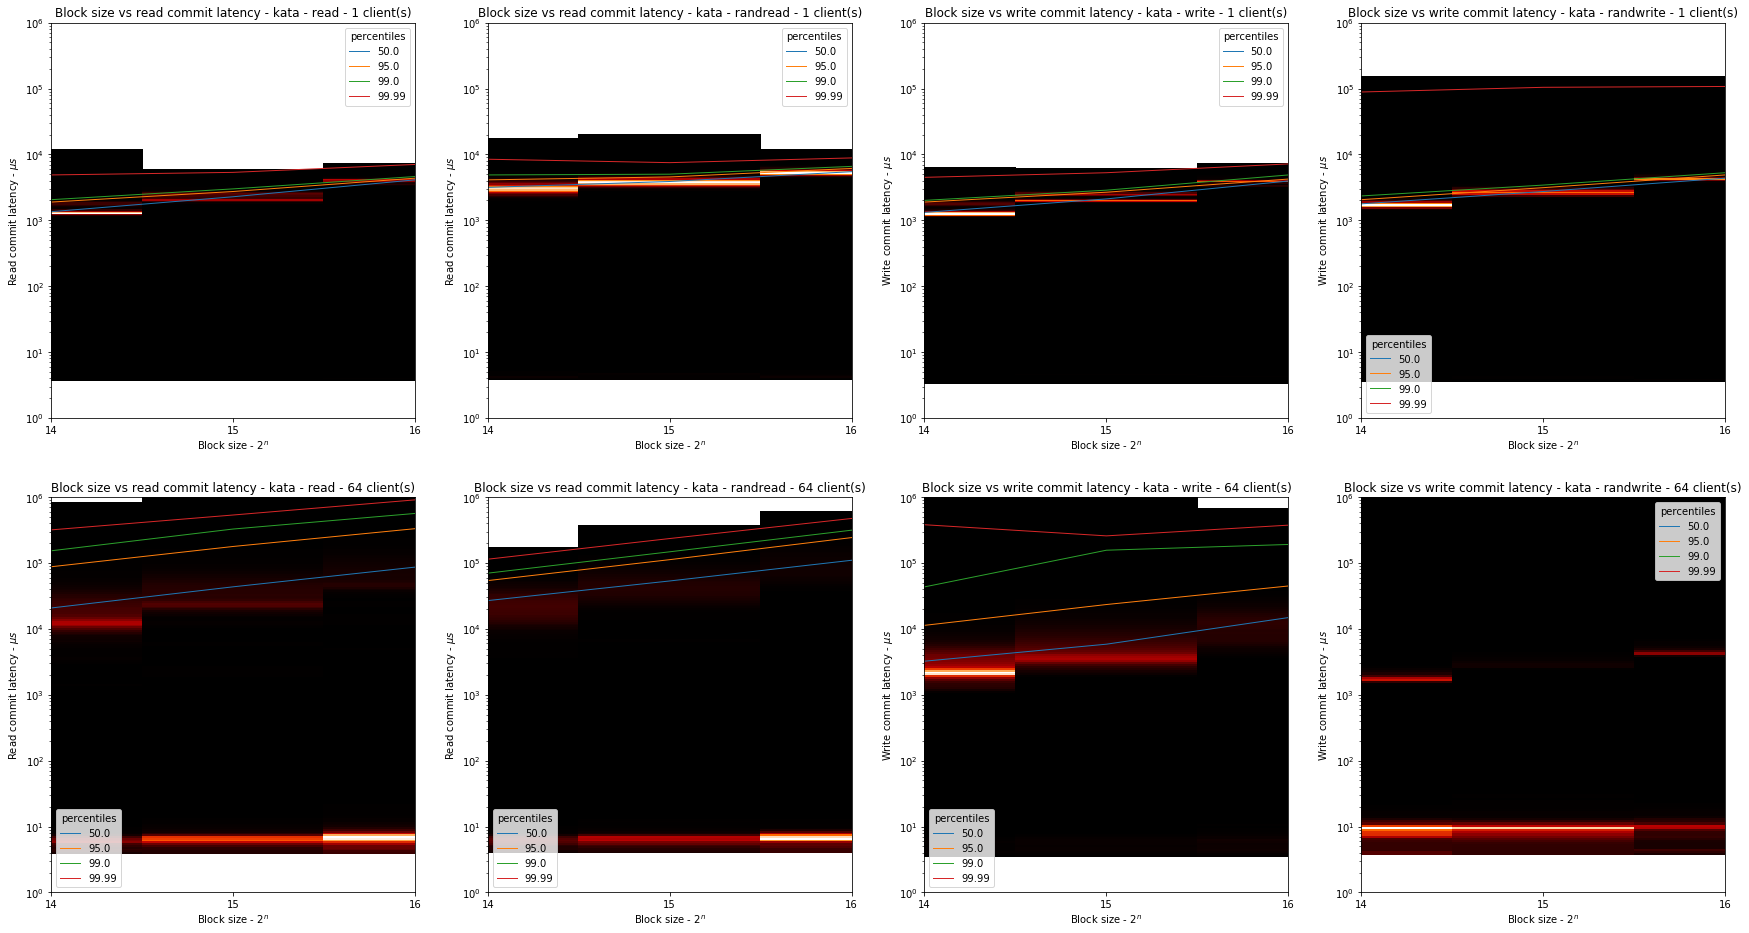

In [42]:
cg = {}
scenarios = ['bare', 'runc', 'kata']
for scenario in scenarios:
    cg[scenario] = clatgrid_helper(scenario)

In [43]:
cg

{'bare': {1: {'randread': <fiotools.ClatGrid instance at 0x7f9ced870a28>,
   'randwrite': <fiotools.ClatGrid instance at 0x7f9cec479320>,
   'read': <fiotools.ClatGrid instance at 0x7f9ced870ab8>,
   'write': <fiotools.ClatGrid instance at 0x7f9ce6bb2998>},
  64: {'randread': <fiotools.ClatGrid instance at 0x7f9cf3724a28>,
   'randwrite': <fiotools.ClatGrid instance at 0x7f9ce6b53dd0>,
   'read': <fiotools.ClatGrid instance at 0x7f9cf503cab8>,
   'write': <fiotools.ClatGrid instance at 0x7f9cebfa4680>}},
 'kata': {1: {'randread': <fiotools.ClatGrid instance at 0x7f9cd992f128>,
   'randwrite': <fiotools.ClatGrid instance at 0x7f9cd96f4950>,
   'read': <fiotools.ClatGrid instance at 0x7f9cd992f170>,
   'write': <fiotools.ClatGrid instance at 0x7f9cd93fe098>},
  64: {'randread': <fiotools.ClatGrid instance at 0x7f9cd8d65200>,
   'randwrite': <fiotools.ClatGrid instance at 0x7f9cd62fef80>,
   'read': <fiotools.ClatGrid instance at 0x7f9cd8e377a0>,
   'write': <fiotools.ClatGrid instance at

In [29]:
!python --version

Python 2.7.5


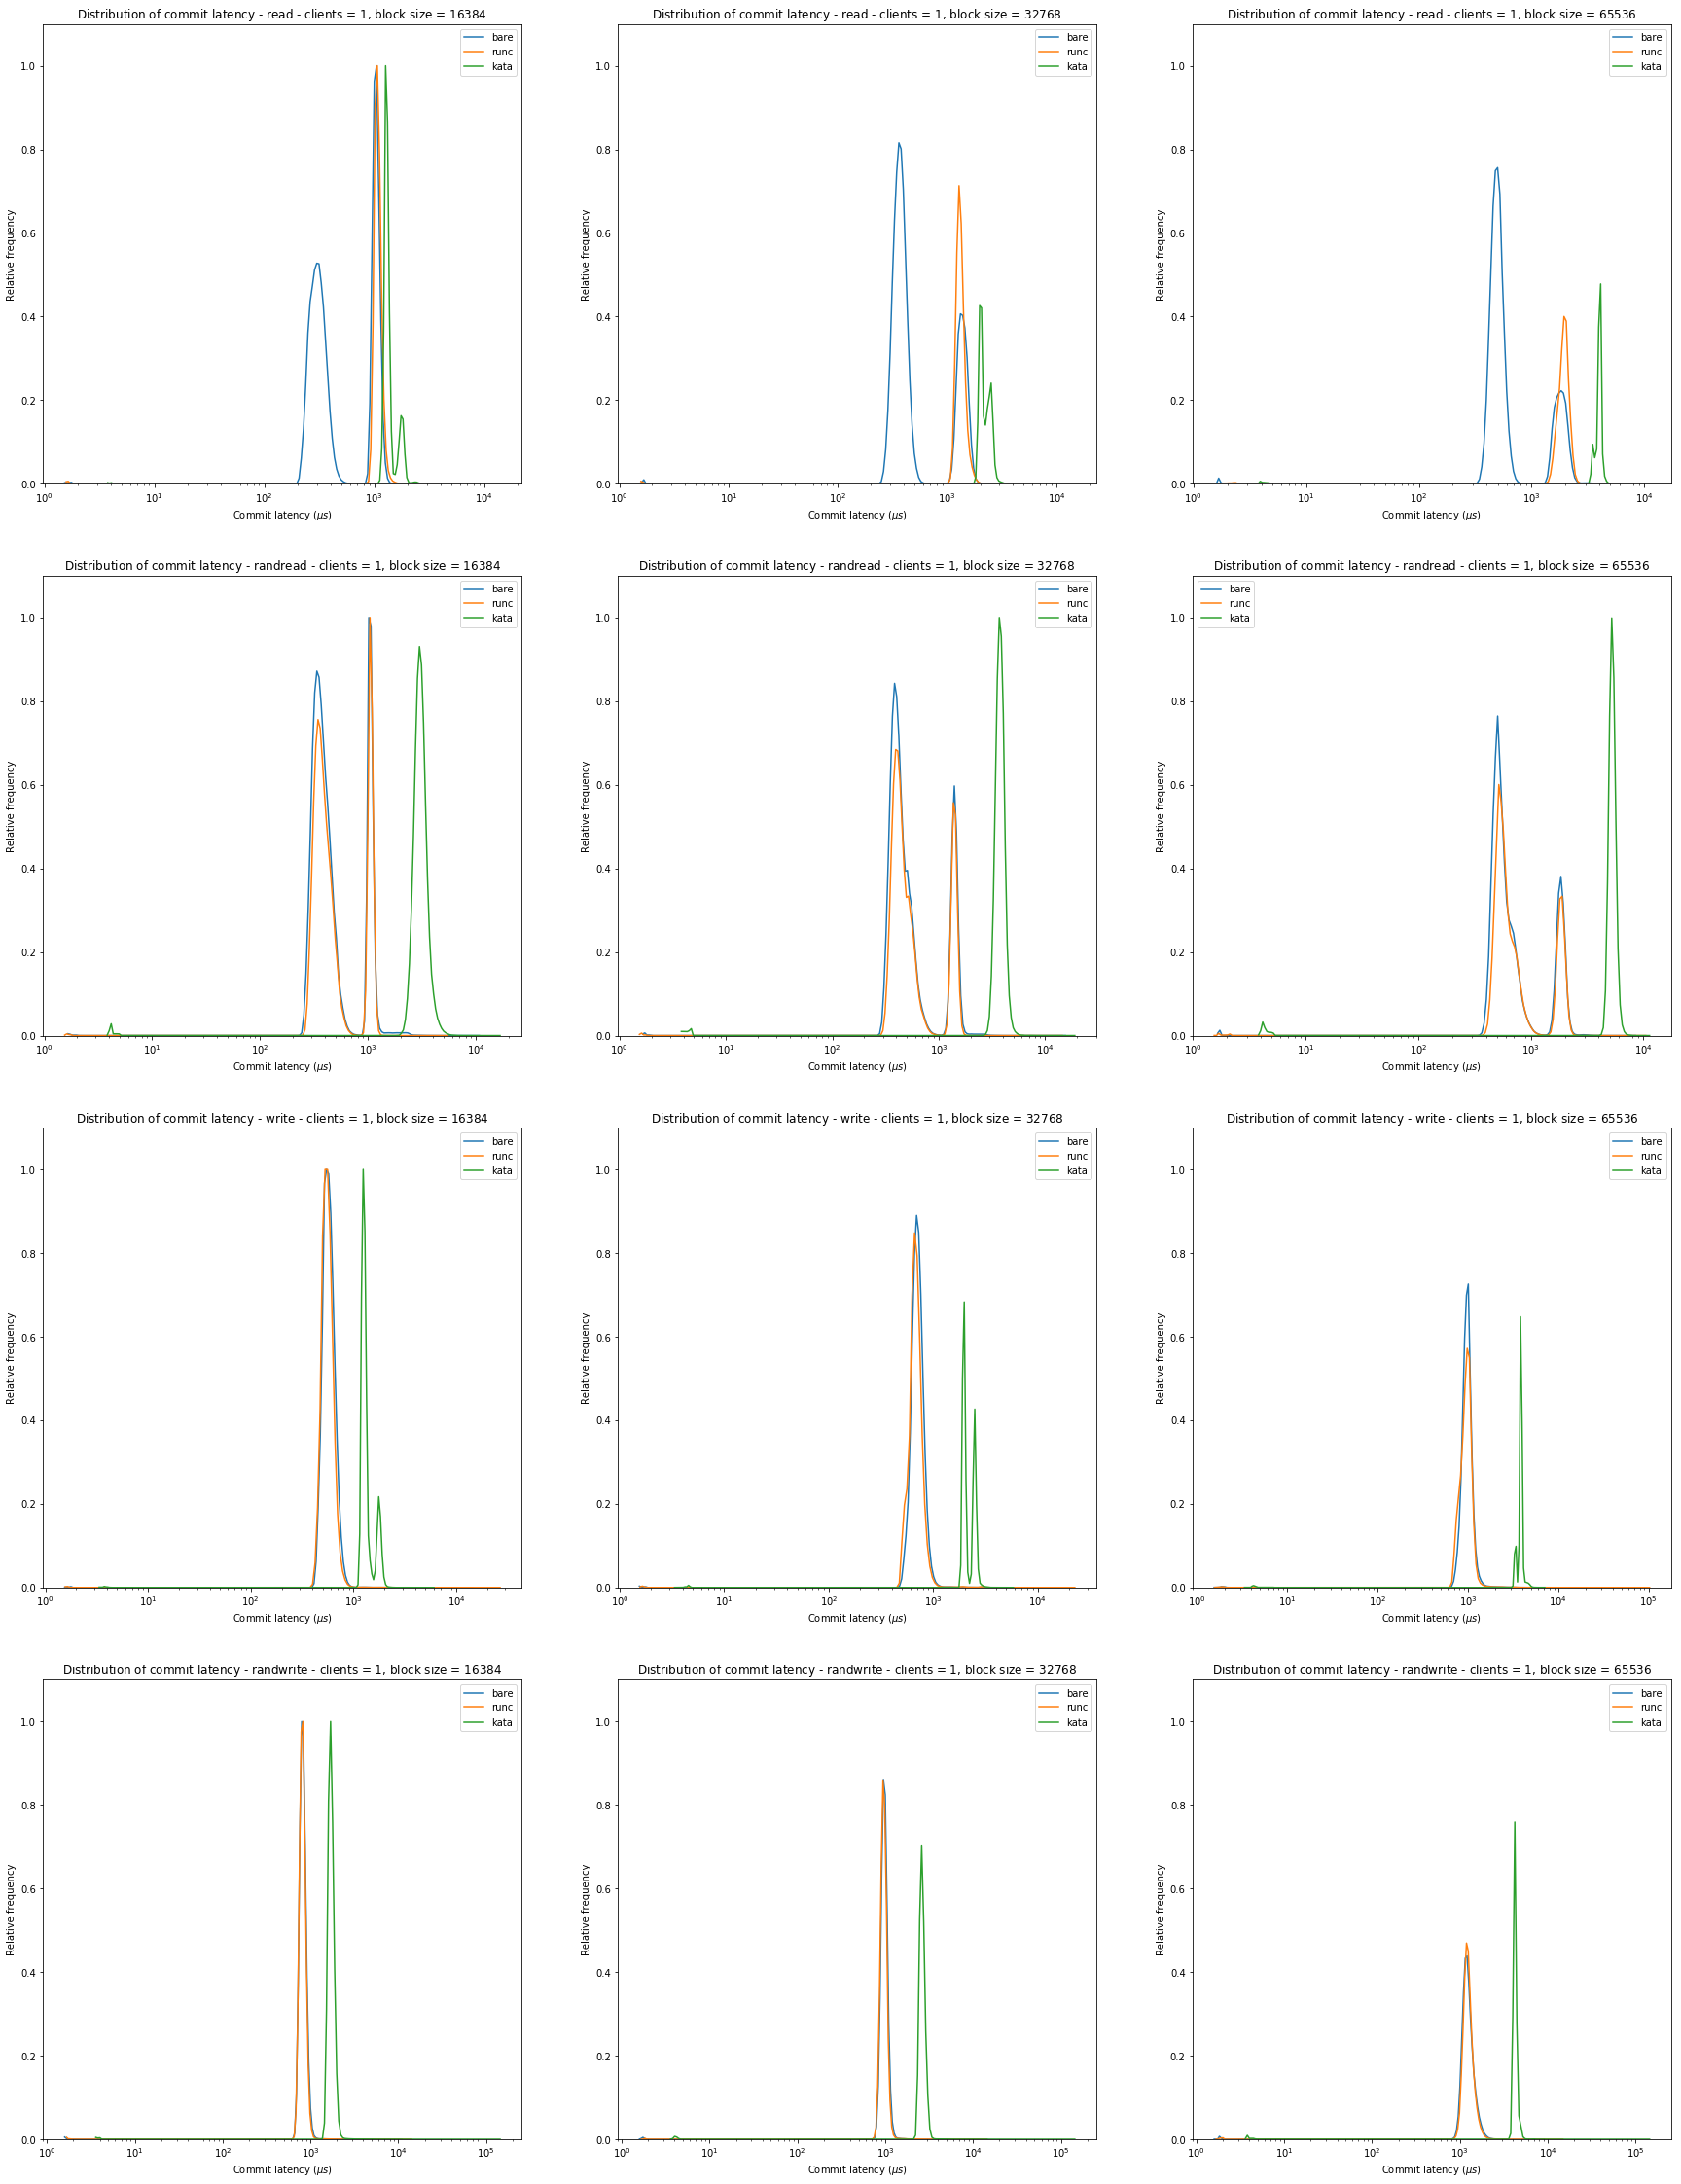

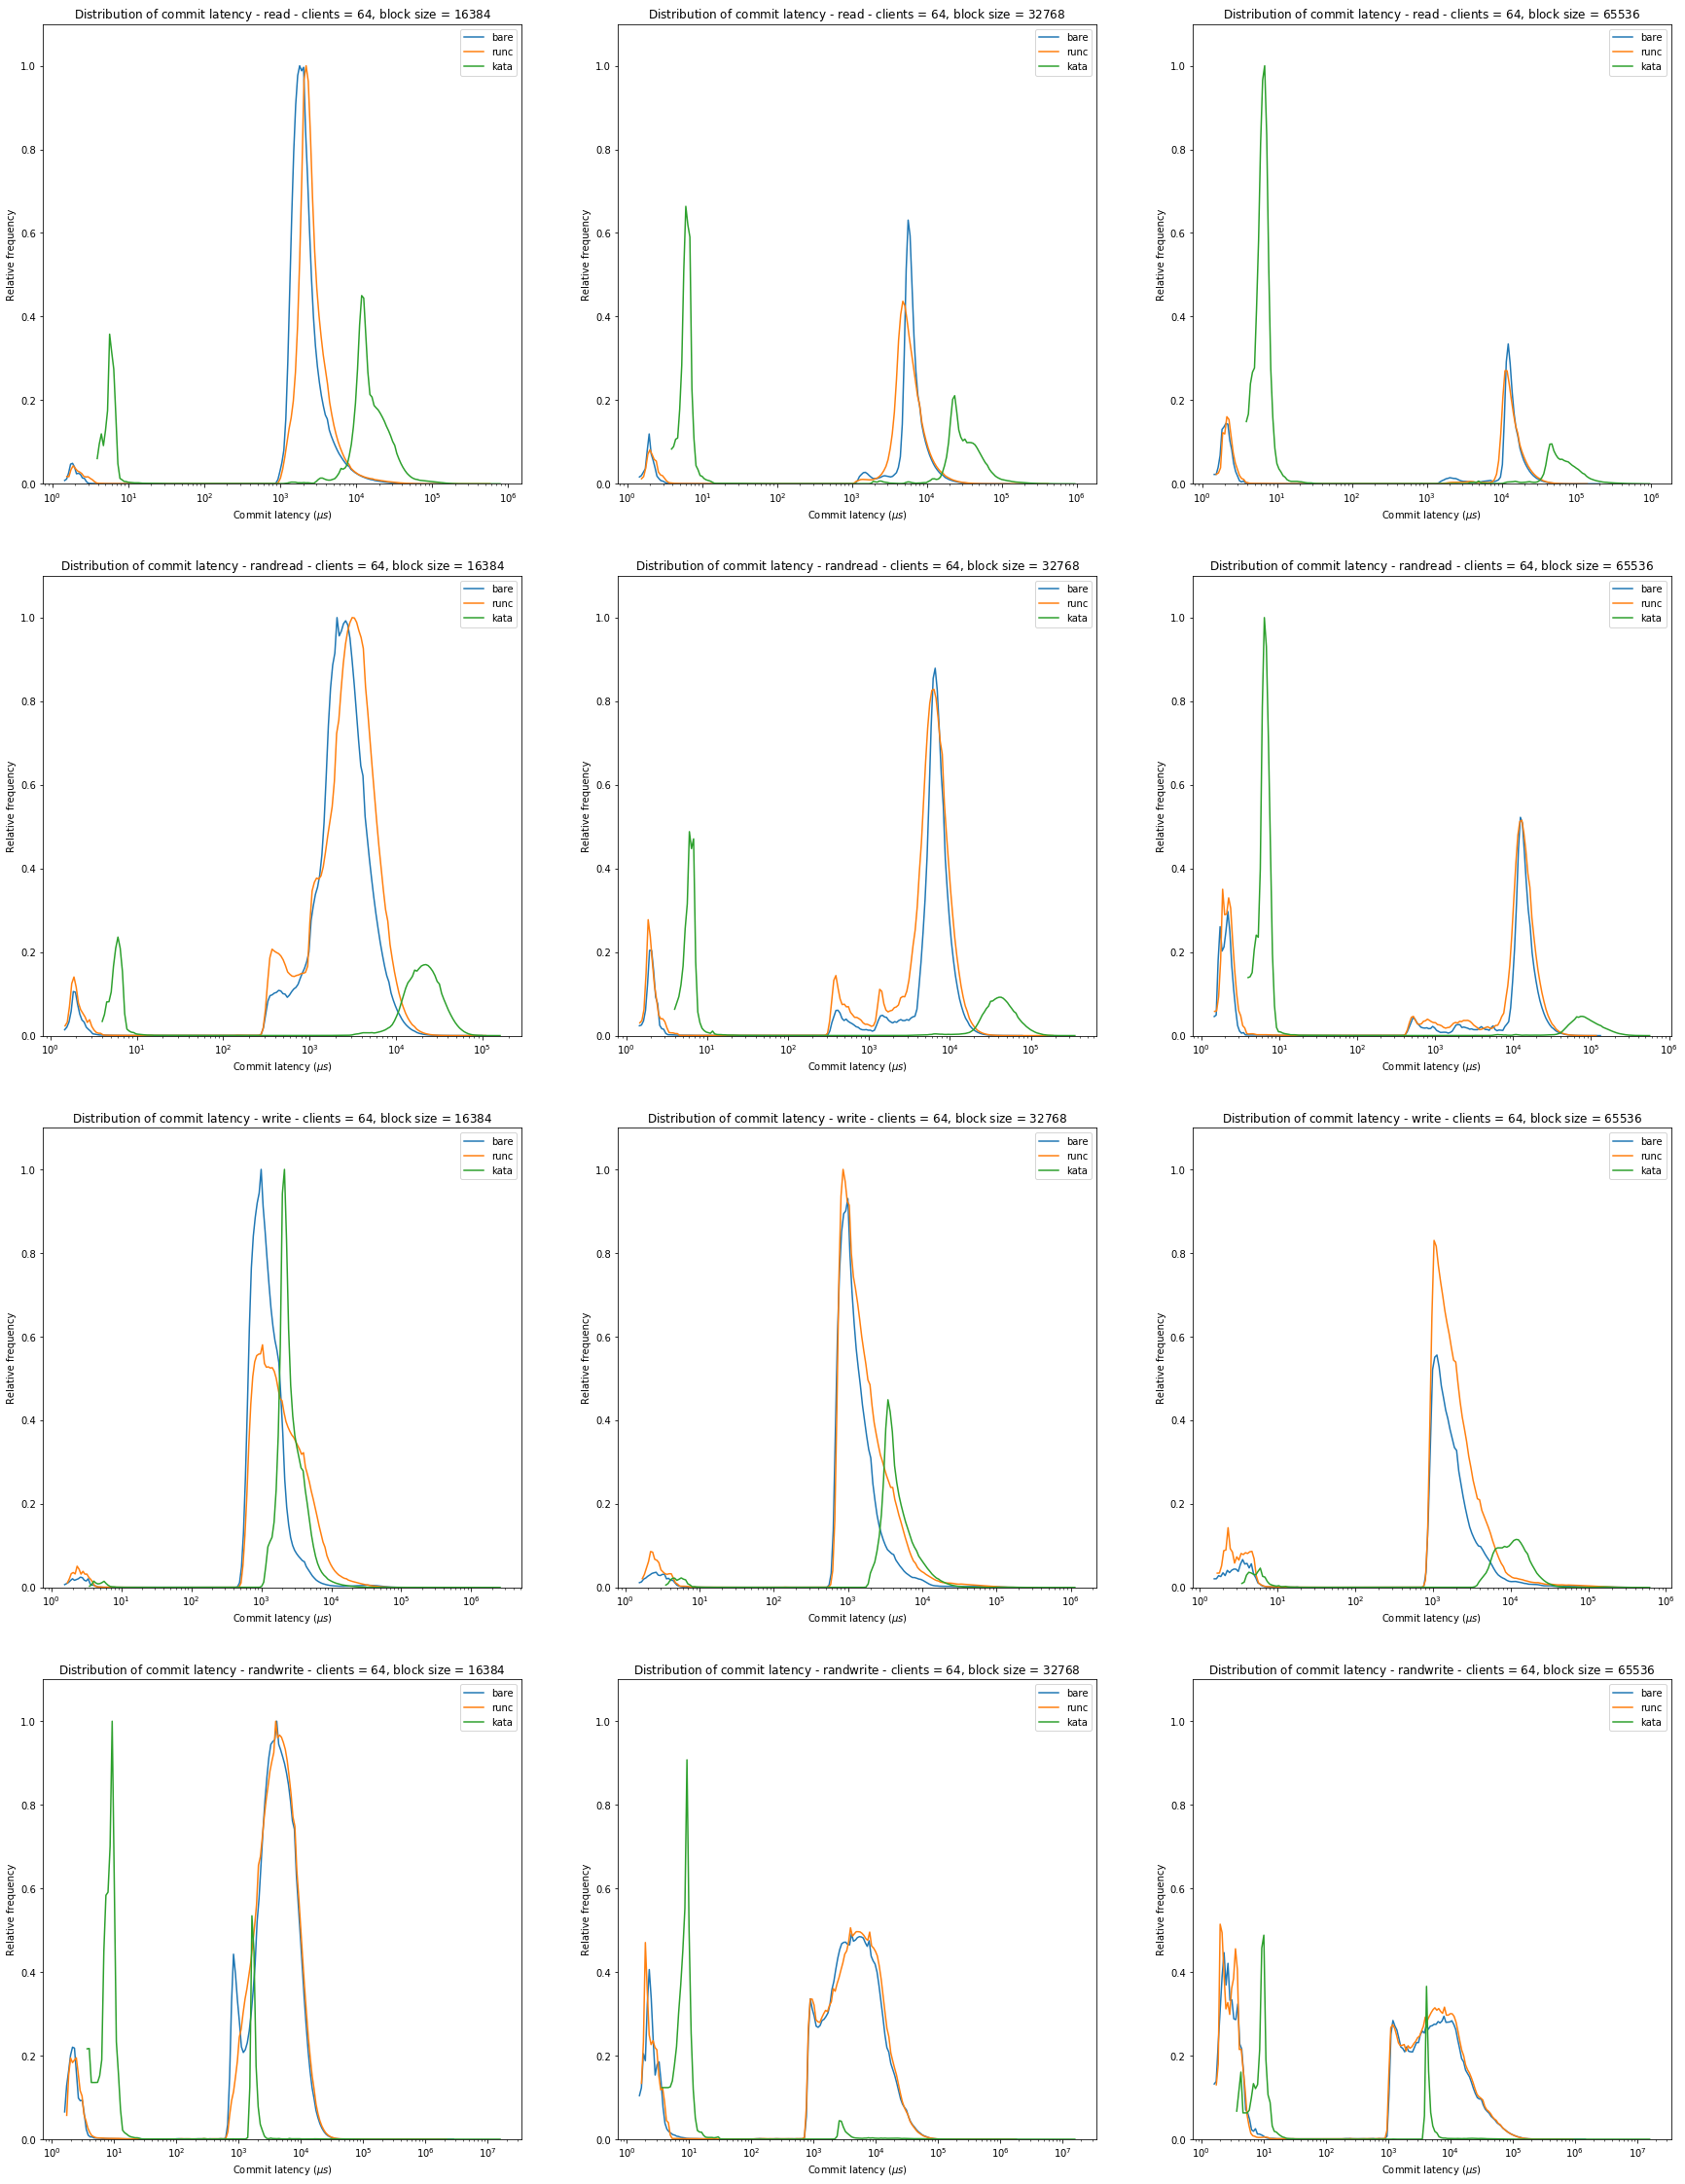

In [49]:
rws = ['read', 'randread', 'write', 'randwrite']
for num_clients in [1, 64]:
    fig, axes = plt.subplots(len(rws), 3, figsize=(30, 40))
    for j, rw in enumerate(rws):
        for i, bs in enumerate([14, 15, 16]):
            ax = axes[j][i]   
            for scenario in scenarios:
                this_cg = cg[scenario][num_clients][rw]
                this_cg.cfdf[bs].plot(ax=ax, logx=True, title='Distribution of commit latency - {rw} - clients = ${num_clients}$, block size = ${bs}$'.format(num_clients=num_clients, rw=rw, bs=2**bs))
            ax.legend(scenarios)
            ax.set_ylim([0, 1.1])
            ax.set_ylabel('Relative frequency')
            ax.set_xlabel('Commit latency (${label}$)'.format(label=this_cg.ts_label))
    fig.savefig('scenario-aggregate-cf-{num_clients}-clients'.format(num_clients=num_clients))

Signature:      bare.cfdf.plot(self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, yerr=None, xerr=None, secondary_y=False, sort_columns=False, **kwds)
Call signature: bare.cfdf.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, yerr=None, xerr=None, secondary_y=False, sort_columns=False, **kwds)
Type:           FramePlotMethods
String form:    <pandas.plotting._core.FramePlotMethods object at 0x7f9ce6fb3810>
File:           ~/venv-openstack/lib/python2.7/site-packa

In [23]:
bare.cfdf

,14,15,16
1.608000e+00,6.538315e-02,1.043827e-01,1.322922e-01
1.729117e+00,1.276773e-01,1.231215e-01,1.381011e-01
1.859356e+00,1.622562e-01,2.047892e-01,2.261926e-01
1.999405e+00,2.010274e-01,1.879628e-01,3.072783e-01
2.150003e+00,2.202683e-01,3.231729e-01,3.890877e-01
2.311944e+00,2.179732e-01,4.060058e-01,4.464605e-01
2.486083e+00,1.573616e-01,3.367888e-01,3.688285e-01
2.673338e+00,9.841733e-02,2.372420e-01,4.208070e-01
2.874697e+00,9.195843e-02,1.534772e-01,3.325277e-01
3.091223e+00,9.335941e-02,1.786681e-01,3.333350e-01


In [24]:
runc=cg['runc']
runc.cfdf

,14,15,16
1.736000e+00,5.718357e-02,1.337866e-01,1.303305e-01
1.863565e+00,1.529609e-01,2.333744e-01,1.796588e-01
2.000504e+00,1.945761e-01,4.705938e-01,5.144765e-01
2.147506e+00,1.832852e-01,3.542433e-01,4.941610e-01
2.305310e+00,1.893753e-01,2.495022e-01,3.948766e-01
2.474709e+00,1.948506e-01,2.263739e-01,3.118342e-01
2.656557e+00,1.572364e-01,2.357071e-01,3.271210e-01
2.851767e+00,1.163232e-01,2.196395e-01,2.985495e-01
3.061321e+00,1.034492e-01,2.141165e-01,3.606192e-01
3.286274e+00,5.950955e-02,1.531834e-01,3.844057e-01


In [39]:
bare.ts_label

'\\mu s'